In [1]:
import cv2
import numpy as np
import glob
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score
from tqdm import tqdm
import sys

In [2]:
# TODO: store the images as matrices or tensors as they take forever to load.
path = "/kaggle/input/deepglobe-land-cover-classification-dataset/"

input_shape = (512, 512, 3)
out_shape = (512, 512, 3)
img_shape = (2448, 2448, 3)

In [3]:
def preprocess_img(img, shape):
    
    image = cv2.imread(img)
    assert image is not None
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    out = np.array(cv2.resize(image, shape, interpolation = cv2.INTER_LINEAR),
                   dtype = np.float32)
    return out
    
def preprocess_mask(img, shape):
    
    mask = np.array(np.round(preprocess_img(img, shape) / 255.0), dtype = np.uint8)
    mask_refined = 4 * mask[:,:,0] + 2 * mask[:,:,1] + mask[:,:,2]
    mask_refined = mask_refined * (mask_refined != 7) + 4 * (mask_refined == 7)
    
    return mask_refined

def get_dataset(path):
    
    mask_dirs = sorted(glob.glob(os.path.join(path,"*_mask.png")))
    sat_dirs = [d.replace("_mask.png", "_sat.jpg") for d in mask_dirs]
    
    X = tf.convert_to_tensor([preprocess_img(file, input_shape[:2]) for file in sat_dirs], dtype = tf.float32)
    y = tf.convert_to_tensor([preprocess_mask(file, out_shape[:2]) for file in mask_dirs], dtype = tf.uint8)
    
    return X, y

In [4]:
X, y = get_dataset(os.path.join(path, "train"))
X = X / 255.0
#X_val, y_val = get_dataset(os.path.join(path, "valid"))
#X_test, y_test = get_dataset(os.path.join(path, "test"))

In [5]:
class ConvBlock(tf.keras.Layer):
    
    def __init__(self, n_filters, filter_size):
        super().__init__()
        self.cn1 = tfl.Conv2D(n_filters, filter_size,
                            padding = "same")
        self.cn2 = tfl.Conv2D(n_filters, filter_size,
                            padding = "same")
        self.relu1 = tfl.ReLU()
        self.relu2 = tfl.ReLU()
        
    def call(self, x):
        x = self.relu1(self.cn1(x))
        x = self.relu2(self.cn2(x))
        return x
        

In [6]:
class UNetConv(ConvBlock):
    def __init__(self, n_filters, filter_size, pool_stride):
        super().__init__(n_filters, filter_size)
        self.pool = tfl.MaxPooling2D(pool_stride)

    def call(self, x):
        x = super().call(x)
        return x, self.pool(x)
        
    
class UNetTConv(ConvBlock):
    def __init__(self, filters, filter_size, tfilters, tfilter_size):
        super().__init__(filters, filter_size)
        self.dcn = tfl.Conv2DTranspose(tfilters, tfilter_size, tfilter_size, padding = "same")

    def call(self, x):
        return self.dcn(super().call(x))

In [7]:
n_blocks = 4
log_conv_filters = 6
n_classes = 7
filter_size = 3
tfilter_size = 2

In [8]:
class UNET(tf.keras.Model):
    
    def __init__(self, blocks):
        super().__init__()
        self.convs = [UNetConv(int(2**(log_conv_filters+i)), filter_size, 2) for i in range(blocks)]
        self.tconvs = [UNetTConv(int(2**(log_conv_filters + blocks -i)), filter_size,\
                int(2**(log_conv_filters + blocks -i)), tfilter_size) for i in range(blocks)]

        self.convf = ConvBlock(int(2**(log_conv_filters)), filter_size)
        self.conv1x1 =  tfl.Conv2D(n_classes, 1, padding = "same")
        self.softmax = tfl.Softmax(axis = -1)
    
    def call(self, x):
        xs = []
        for conv in self.convs:
            skip, x = conv(x)
            xs.append(skip)

        skip = None
        for tconv in self.tconvs:
            x = x if skip is None else tf.concat([skip, x], axis = -1)
            x = tconv(x)
            skip = xs.pop()
            
        x = self.convf(tf.concat([skip, x], axis = -1))
        x = self.softmax(self.conv1x1(x))
        
        return x

In [9]:
inputs = tf.keras.Input(input_shape)
model = UNET(n_blocks)
model(inputs)

<KerasTensor shape=(None, 512, 512, 7), dtype=float32, sparse=False, name=keras_tensor_15>

In [10]:
model.build(input_shape = input_shape)
model.summary()

Model: "unet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ u_net_conv (UNetConv)           │ ?                      │        38,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_1 (UNetConv)         │ ?                      │       221,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_2 (UNetConv)         │ ?                      │       885,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_conv_3 (UNetConv)         │ ?                      │     3,539,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv (UNetTConv)        │ ?                      │    18,353,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_1 (UNetTConv)      │ ?                      │    10,487,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_2 (UNetTConv)      │ ?                      │     2,622,208 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ u_net_t_conv_3 (UNetTConv)      │ ?                      │       655,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_block (ConvBlock)          │ ?                      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ ?                      │           455 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax (Softmax)               │ ?                      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 36,951,815 (140.96 MB)

 Trainable params: 36,951,815 (140.96 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
f1 = tf.keras.metrics.F1Score(average = "macro")

def f1_score_images(y_true, y_pred):
    y_true_flat = tf.one_hot(tf.reshape(y_true,(-1,)), n_classes)
    y_pred_flat = tf.one_hot(tf.reshape(tf.argmax(y_pred, axis = -1), (-1,)), n_classes)
    return f1(y_true_flat, y_pred_flat)

In [12]:
lr = 1e-3
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False)
optimizer = tf.keras.optimizers.AdamW(lr)
model.compile(loss = loss_fn, optimizer = optimizer, metrics = [f1_score_images])

In [13]:
def to_img(y):
    
    out = np.zeros(y.shape[:2] + (3,))
    
    out[:, :, 0] = (y // 4) * 255
    out[:, :, 1] = ((y % 4) // 2) * 255
    out[:, :, 2] = (y % 2) * 255

    return out

In [14]:
# history = model.fit(X_train, y_train, epochs = EPOCHS, batch_size = 2, validation_split = 0.2).history

In [15]:
train_split = 0.8
n = int(train_split * X.shape[0])

X_train, X_val = X[:n], X[n:]
y_train, y_val = y[:n], y[n:]

In [16]:
aug = tf.keras.Sequential([tfl.RandomTranslation(0.1,0.1), tfl.RandomRotation(0.2, seed=42)])

In [17]:
@tf.function
def train_step(X, y):

    y_float = tf.cast(tf.reshape(y, y.shape + (1,)), tf.float32)
    data = tf.concat([X, y_float], axis = -1)
    data_aug = aug(data, training = True)
    X_aug = data_aug[..., : -1]
    y_aug = tf.cast(data_aug[..., -1], tf.uint8)

    with tf.GradientTape() as tape:
        preds = model(X_aug)
        loss = loss_fn(y_aug, preds)
    f1_score = f1_score_images(y_aug, preds)

    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    return loss, f1_score

In [18]:
@tf.function
def val_step(X, y):
    preds = model(X)
    loss = loss_fn(y, preds)
    f1_score = f1_score_images(y, preds)
    return loss, f1_score

In [19]:
EPOCHS = 200
history = {}
batch_size = 2

stderr = sys.stderr
sys.stderr = sys.stdout

In [20]:
for epoch in range(EPOCHS):
    train_loss, train_f1 = 0, 0
    
    for i in tqdm(range(0, X_train.shape[0], batch_size)):
        X_batch = X_train[i: i + batch_size]
        y_batch = y_train[i: i + batch_size]
        loss, f1_score = train_step(X_batch, y_batch)
        train_loss += loss * X_batch.shape[0]
        train_f1 += f1_score * X_batch.shape[0]

    train_loss /= X_train.shape[0]
    train_f1 /= X_train.shape[0]

    history["loss"] = history.get("loss", []) + [train_loss]
    history["f1"] = history.get("f1", []) + [train_f1]

    val_loss, val_f1 = 0, 0

    for j in range(0, X_val.shape[0], batch_size):
        X_batch = X_val[j: j + batch_size]
        y_batch = y_val[j: j + batch_size]
        loss, f1_score = val_step(X_batch, y_batch)
        val_loss += loss * X_batch.shape[0]
        val_f1 += f1_score * X_batch.shape[0]

    val_loss /= X_val.shape[0]
    val_f1 /= X_val.shape[0]

    history["val_loss"] = history.get("val_loss", []) + [val_loss]
    history["val_f1"] = history.get("val_f1", []) + [val_f1]

    print(f"Epoch {epoch + 1} / {EPOCHS} loss: {train_loss:0.4f}, F1: {train_f1:0.4f}, val_loss: {val_loss:0.4f}, val_f1: {val_f1:0.4f}")

100%|██████████| 321/321 [01:42<00:00,  3.13it/s]
Epoch 1 / 200 loss: 1.5890, F1: 0.1046, val_loss: 1.4183, val_f1: 0.1065
100%|██████████| 321/321 [01:28<00:00,  3.65it/s]
Epoch 2 / 200 loss: 1.3338, F1: 0.1057, val_loss: 1.4014, val_f1: 0.1064
100%|██████████| 321/321 [01:27<00:00,  3.65it/s]
Epoch 3 / 200 loss: 1.2904, F1: 0.1081, val_loss: 1.2723, val_f1: 0.1122
100%|██████████| 321/321 [01:27<00:00,  3.65it/s]
Epoch 4 / 200 loss: 1.2667, F1: 0.1188, val_loss: 1.4149, val_f1: 0.1248
100%|██████████| 321/321 [01:27<00:00,  3.65it/s]
Epoch 5 / 200 loss: 1.2548, F1: 0.1320, val_loss: 1.2023, val_f1: 0.1366
100%|██████████| 321/321 [01:28<00:00,  3.65it/s]
Epoch 6 / 200 loss: 1.2167, F1: 0.1435, val_loss: 1.1905, val_f1: 0.1503
100%|██████████| 321/321 [01:28<00:00,  3.65it/s]
Epoch 7 / 200 loss: 1.2075, F1: 0.1563, val_loss: 1.1571, val_f1: 0.1615
100%|██████████| 321/321 [01:28<00:00,  3.65it/s]
Epoch 8 / 200 loss: 1.1860, F1: 0.1677, val_loss: 1.1568, val_f1: 0.1733
100%|██████████|

In [21]:
# We reconfigure stderr to default
sys.stderr = stderr

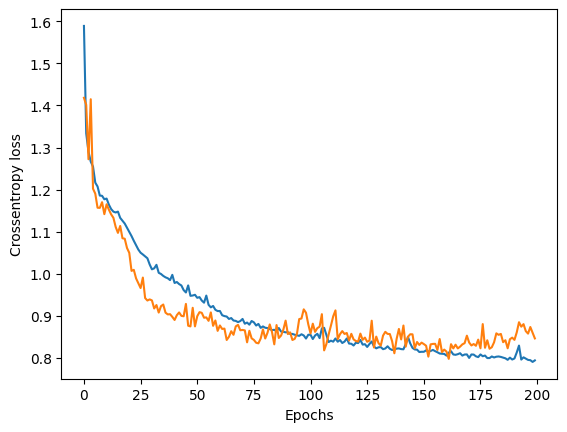

In [22]:
plt.plot(history["loss"])
plt.plot(history["val_loss"])
plt.xlabel("Epochs")
plt.ylabel("Crossentropy loss")
plt.show()

In [23]:
def predict_mask(X_target):
    if len(X_target.shape) == 3:
        # Add batch dimension
        X_target = tf.reshape(X_target, (1,) + X_target.shape)
        
    y_pred = tf.argmax(model(X_target), axis = -1)[0]
    
    return y_pred

In [24]:
import seaborn as sns

def confusion_matrix_show(cm):
    class_labels = list(range(n_classes))
    sns.heatmap(cm, 
                annot=True,
                fmt='g', 
                cmap='Blues',
                xticklabels=class_labels, 
                yticklabels=class_labels)
    
    plt.ylabel('Actual', fontsize=13)
    plt.title('Confusion Matrix', fontsize=17, pad=20)
    plt.gca().xaxis.set_label_position('top')
    plt.xlabel('Prediction', fontsize=13)
    plt.gca().xaxis.tick_top()
    
    plt.gca().figure.subplots_adjust(bottom=0.2)
    plt.gca().figure.text(0.5, 0.05, 'Prediction', ha='center', fontsize=13)
    plt.show()

In [25]:
def Visualize_output(X_target, y_target):
    y_pred = predict_mask(X_target)
    img_pred = to_img(y_pred)
    img_real = to_img(y_target)

    y_target_flat = tf.reshape(y_target,-1)
    y_pred_flat = tf.reshape(y_pred, -1)

    cm = confusion_matrix(y_target_flat, y_pred_flat, labels = np.arange(n_classes))
    confusion_matrix_show(cm)
    print(f"F1 Score: {f1_score_images(y_target_flat, y_pred_flat)}")
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot first image
    axes[0].imshow(img_pred, interpolation = 'nearest')
    axes[0].axis('off')
    axes[0].set_title("Predicted mask:")
    
    # Plot second image
    axes[1].imshow(img_real, interpolation = 'nearest')
    axes[1].axis('off')
    axes[1].set_title("Real mask:")
    
    # Display the images
    plt.tight_layout()
    plt.show()

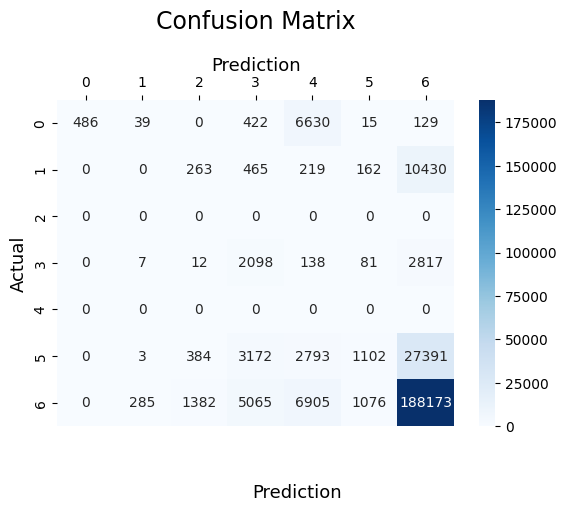

F1 Score: 0.46427878737449646


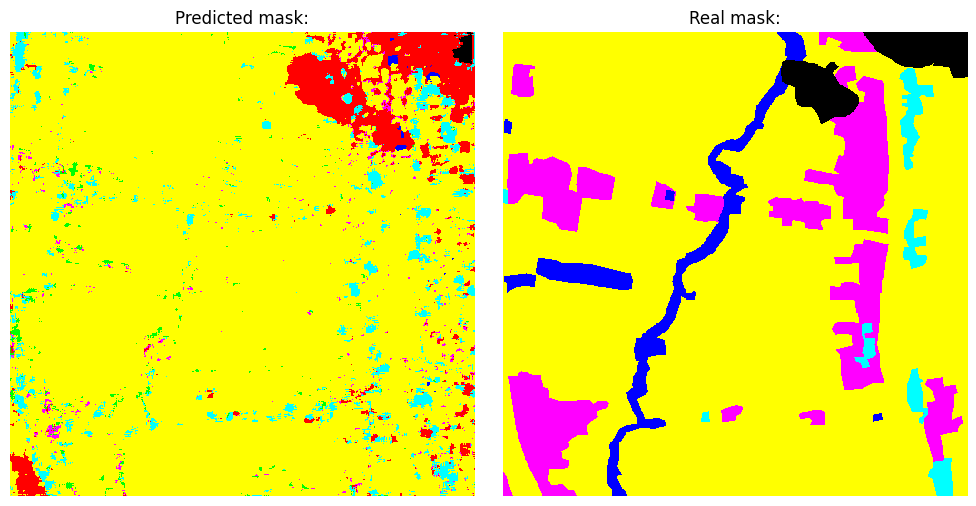

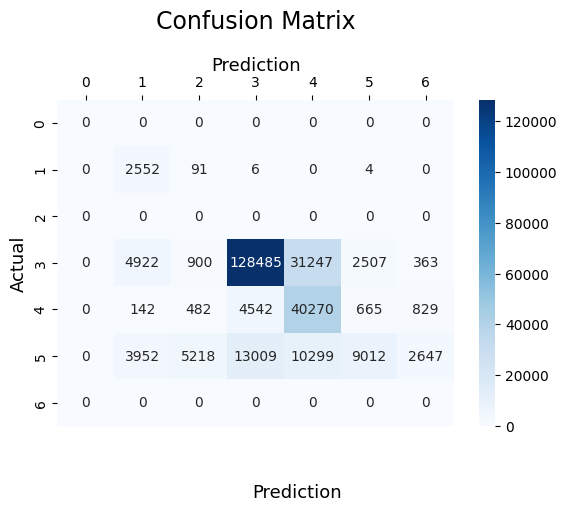

F1 Score: 0.4642765522003174


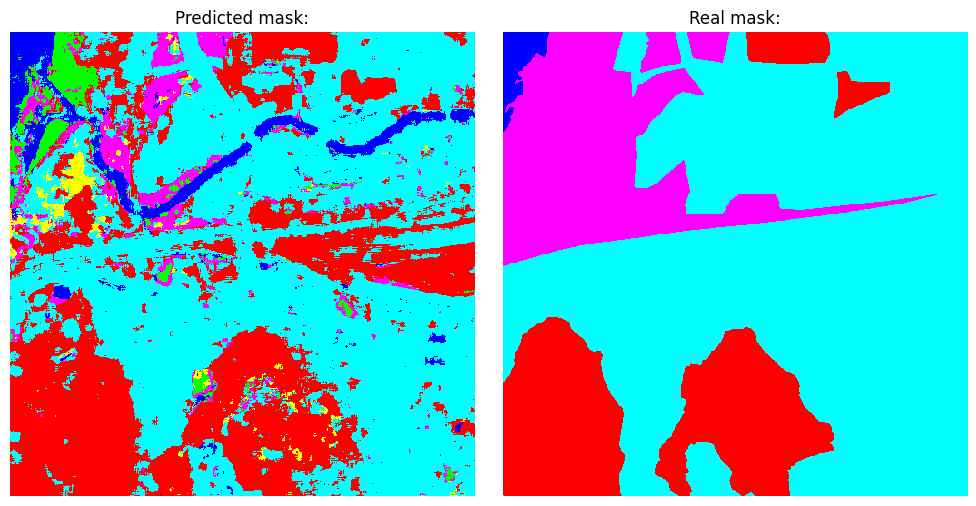

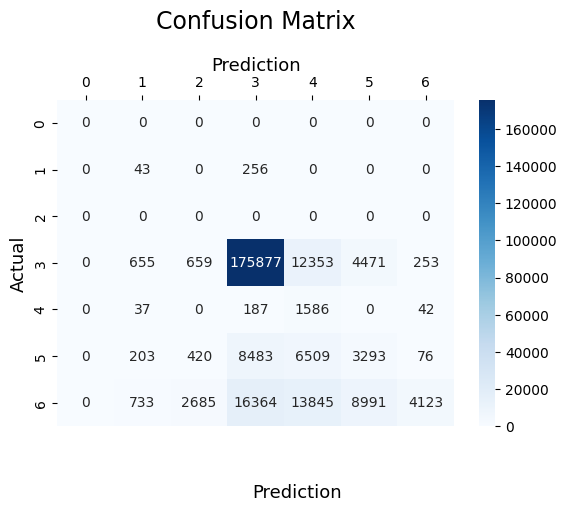

F1 Score: 0.4642745554447174


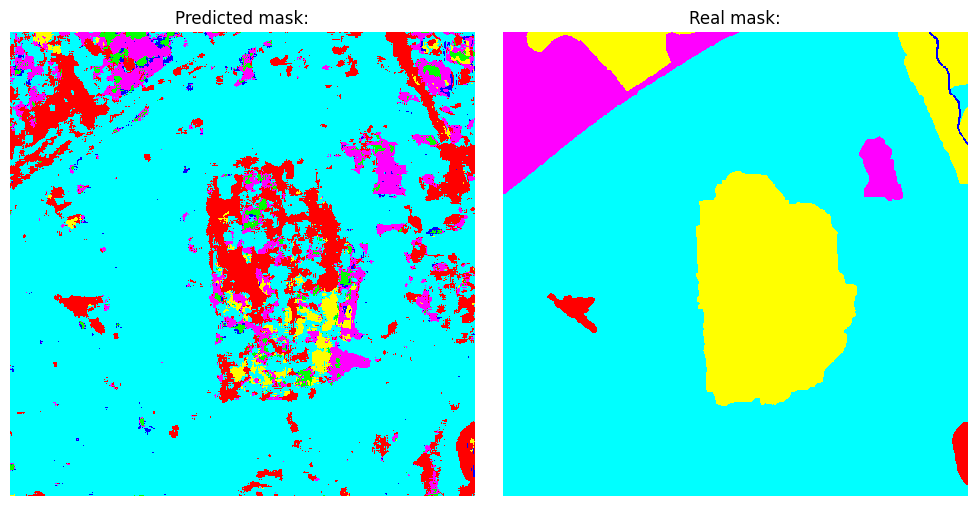

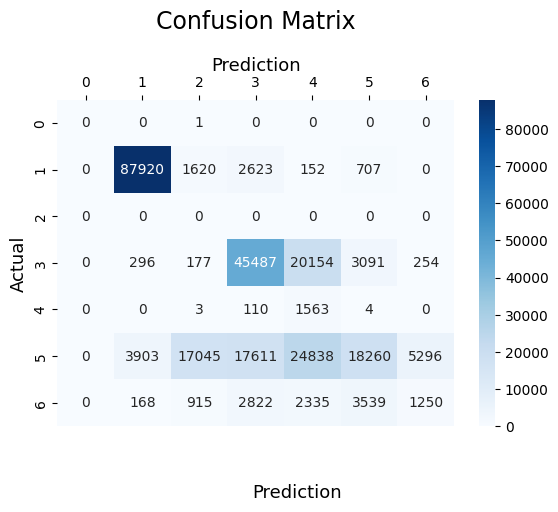

F1 Score: 0.4642699360847473


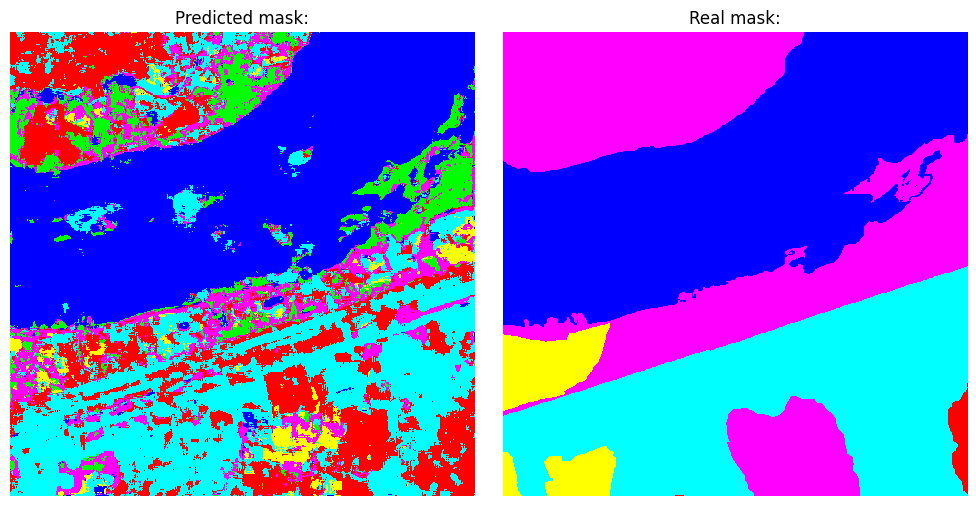

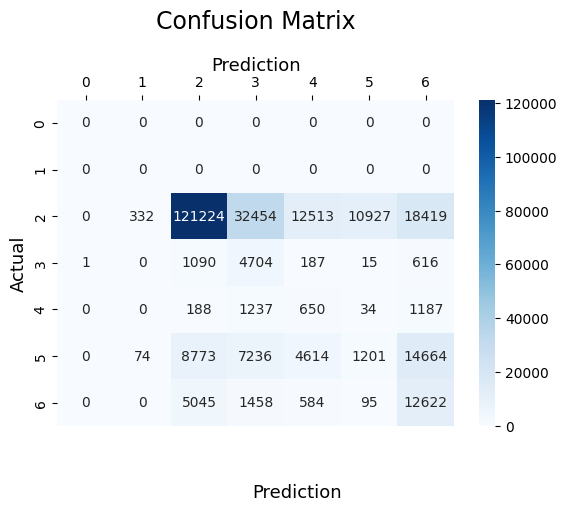

F1 Score: 0.4642699062824249


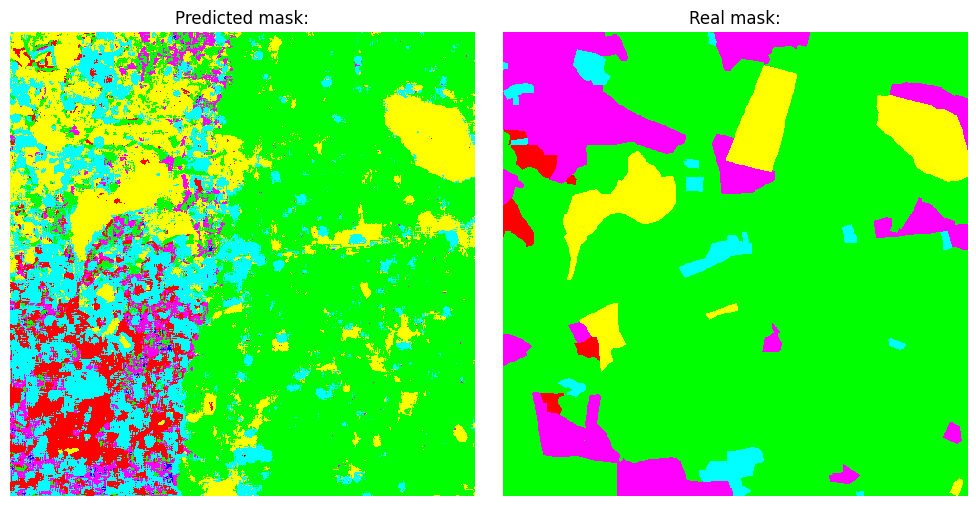

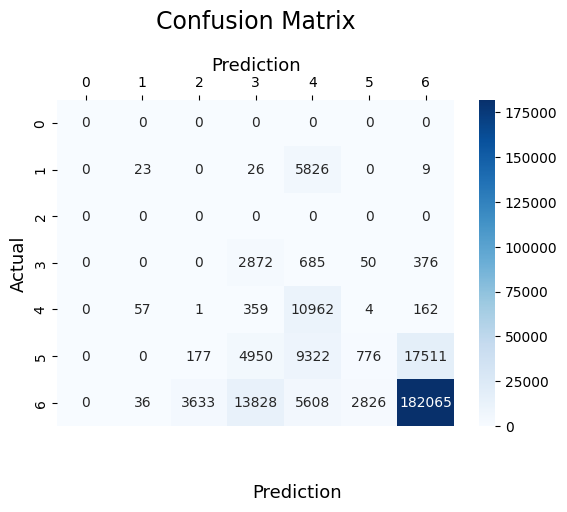

F1 Score: 0.4639577567577362


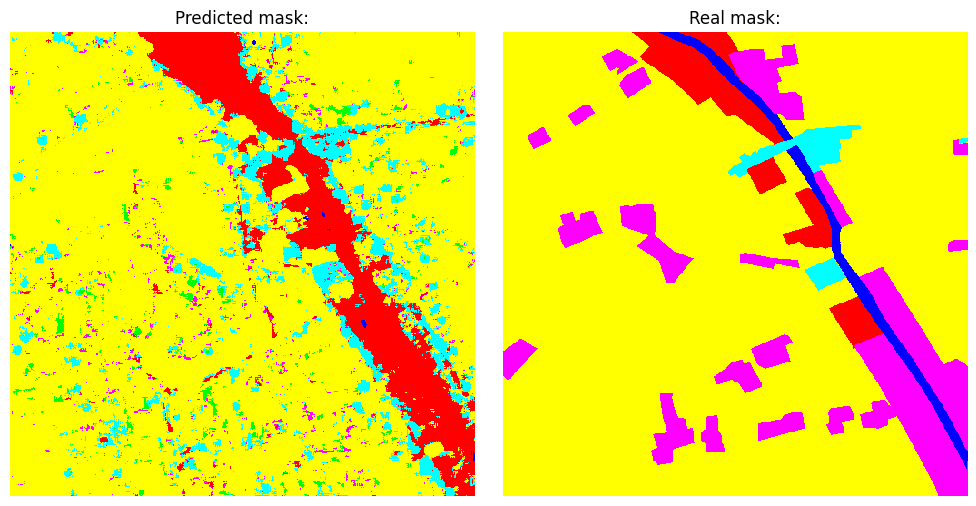

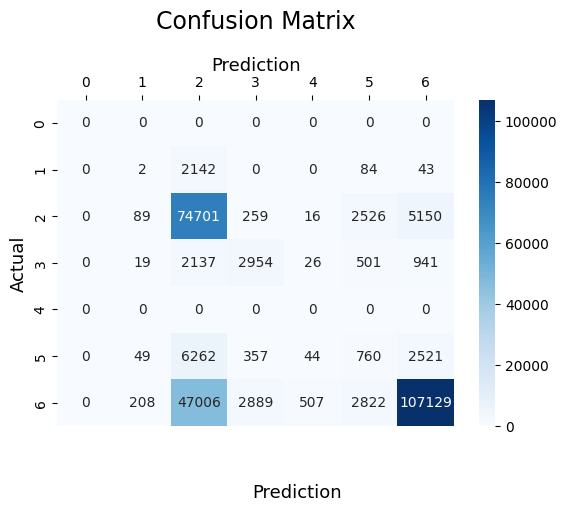

F1 Score: 0.463651567697525


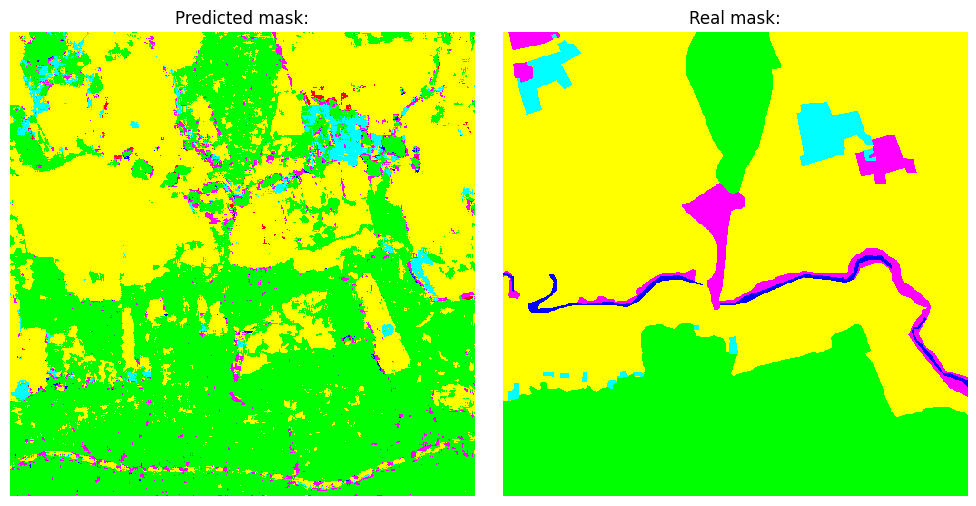

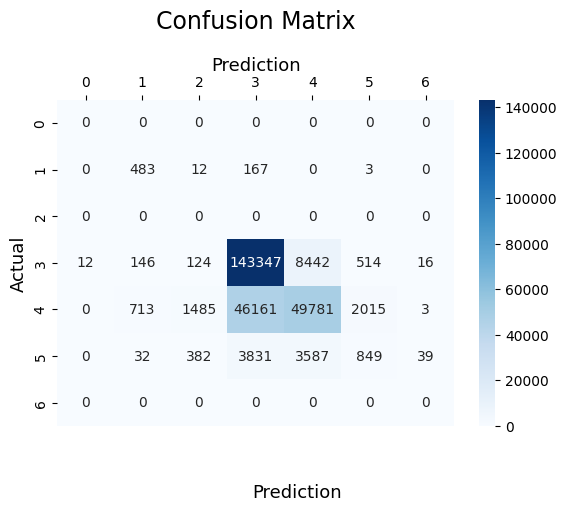

F1 Score: 0.46364912390708923


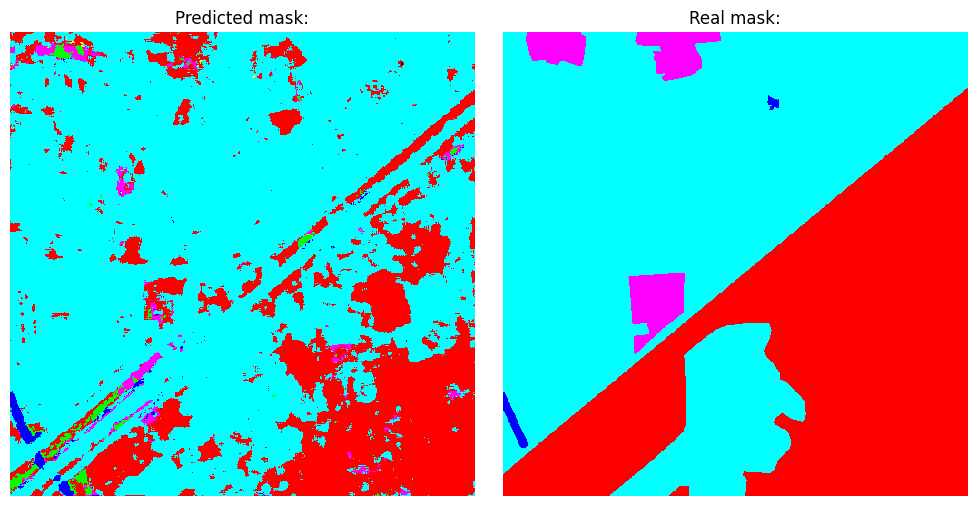

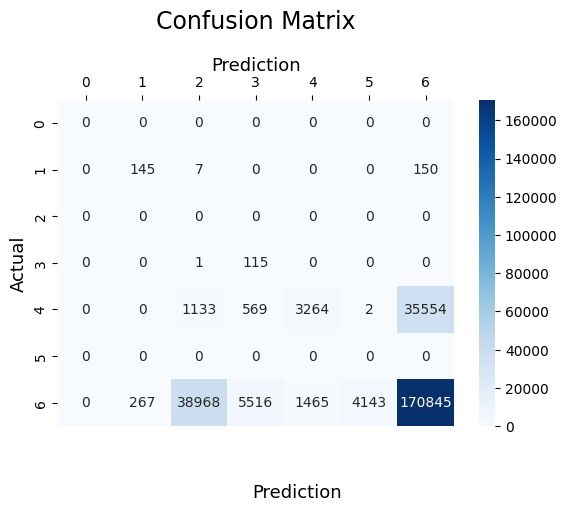

F1 Score: 0.4633494019508362


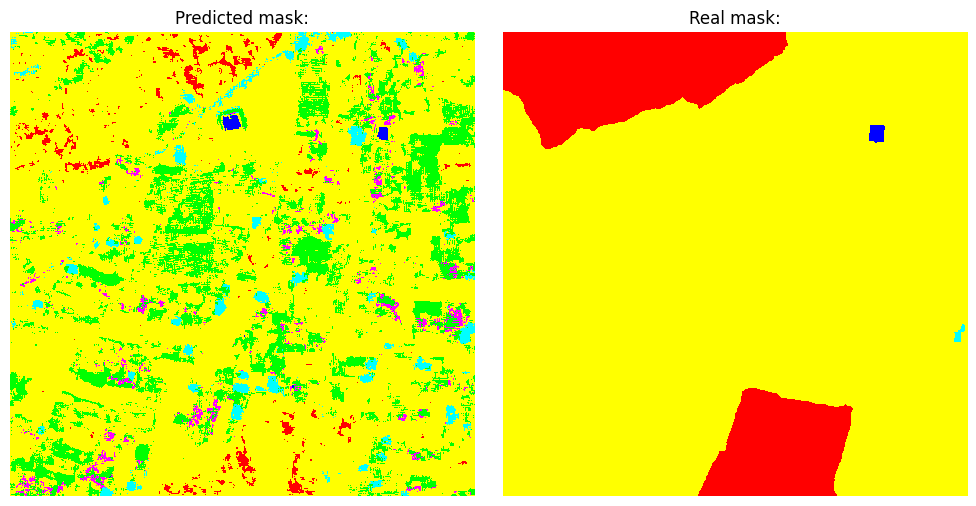

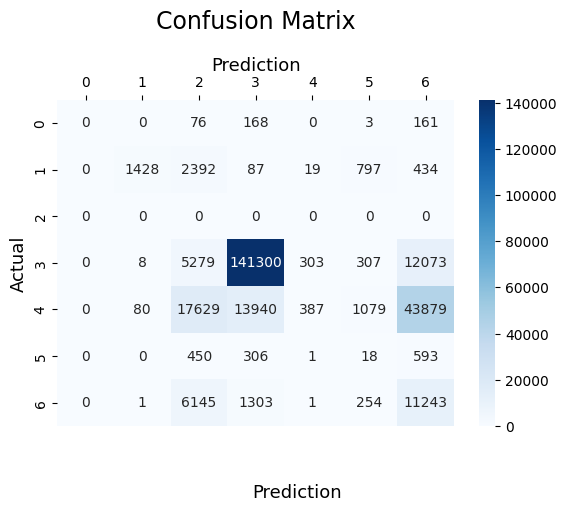

F1 Score: 0.4630579948425293


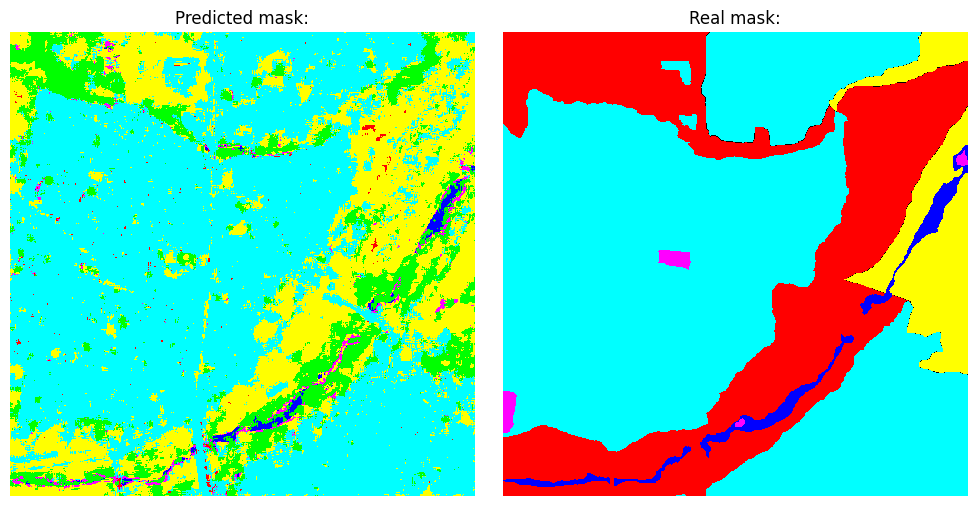

In [26]:
random_indices = np.random.randint(0, X_train.shape[0], 10)
for i in random_indices:
    Visualize_output(X_train[i], y_train[i])